# Vacuum Pressure Rate-of-Rise Analysis


Update the configuration cell with your latest measurements, then execute each section in order. Every step now reports its outputs immediately so you can confirm the workflow as you go.


## 1. Imports & Dependencies

Load the scientific stack and utility functions required for the analysis.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path
from scipy.optimize import curve_fit

INHG_TO_BAR = 0.0338638866667
ATMOSPHERE_BAR = 1.01325


## 2. Configure Input Data

Edit the measurement list, gauge settings, and metadata before running the rest of the notebook.

In [9]:
# User-editable inputs

data_inhg = [
    ("2025-10-30 17:30", -28.0),
    ("2025-10-31 17:30", -26.0),
    ("2025-11-03 09:45", -22.0),
    ("2025-11-04 16:30", -20.0),
    ("2025-11-06 11:00", -17.0),
]

data = [
    (timestamp, ATMOSPHERE_BAR + reading_inhg * INHG_TO_BAR)
    for timestamp, reading_inhg in data_inhg
]

VOLUME_L = "4L"                       # Sample volume (liters)
SYSTEM_TEMP_C = 21.0                  # Approximate chamber temperature (C) for water comparison

CURVE_GRID_RANGE = (0.0, 100.0, 0.25)  # (start_hour, stop_hour, step_hour)


## 3. Helper Functions

Utility routines for parsing inputs, fitting models, and unit conversions.

In [10]:
SECONDS_PER_HOUR = 3600.0
R_L_BAR_PER_MOL_K = 0.08314462618
MOLAR_MASS_WATER_G_PER_MOL = 18.01528
MMHG_TO_BAR = 1.33322368421e-3

GAUGE_FULL_SPAN_INHG = 30.0
GAUGE_END_QUARTER_FRACTION = 0.25
GAUGE_RESOLUTION_SIGMA_INHG = 1.0 / np.sqrt(3.0)


def gauge_accuracy_mpe_inhg(reading_inhg):
    abs_reading = abs(reading_inhg)
    quarter_span = GAUGE_FULL_SPAN_INHG * GAUGE_END_QUARTER_FRACTION
    if abs_reading <= quarter_span or abs_reading >= GAUGE_FULL_SPAN_INHG - quarter_span:
        return 0.02 * GAUGE_FULL_SPAN_INHG
    return 0.01 * GAUGE_FULL_SPAN_INHG


def gauge_sigma_inhg(reading_inhg):
    accuracy_sigma = gauge_accuracy_mpe_inhg(reading_inhg) / np.sqrt(3.0)
    return float(np.sqrt(accuracy_sigma ** 2 + GAUGE_RESOLUTION_SIGMA_INHG ** 2))


def parse_volume_liters(value):
    cleaned = str(value).strip().lower().replace(' ', '')
    if cleaned.endswith('l'):
        cleaned = cleaned[:-1]
    return float(cleaned)


def prepare_dataframe(entries):
    df = pd.DataFrame(entries, columns=["timestamp", "pressure_bar"])
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)
    t0 = df.loc[0, "timestamp"]
    df["t_hours"] = (df["timestamp"] - t0).dt.total_seconds() / 3600.0
    return df


def water_vapor_pressure_bar(temp_c):
    temp_c = np.clip(float(temp_c), -10.0, 100.0)
    A, B, C = 8.07131, 1730.63, 233.426
    pressure_mmHg = 10 ** (A - B / (C + temp_c))
    return pressure_mmHg * MMHG_TO_BAR


def linear_model(t, a, b):
    return a + b * t


def asymptotic_model(t, delta_p, tau_hours):
    tau_hours = float(max(tau_hours, 1e-9))
    t_arr = np.asarray(t, dtype=float)
    return ATMOSPHERE_BAR - delta_p * np.exp(-t_arr / tau_hours)


def asymptotic_jacobian(t, delta_p, tau_hours):
    tau_hours = float(max(tau_hours, 1e-9))
    t_arr = np.atleast_1d(np.asarray(t, dtype=float))
    exp_term = np.exp(-t_arr / tau_hours)
    d_delta = -exp_term
    d_tau = -delta_p * exp_term * (t_arr / (tau_hours ** 2))
    return np.column_stack((d_delta, d_tau))


def asymptotic_prediction_sigma(times_array, params, covariance):
    jac = asymptotic_jacobian(times_array, *params)
    var = np.einsum("ij,jk,ik->i", jac, covariance, jac)
    return np.sqrt(np.maximum(var, 0.0))


def fit_model(times, pressures, sigma, model_fn, p0, bounds, param_names, label):
    popt, pcov = curve_fit(
        model_fn,
        times,
        pressures,
        p0=p0,
        sigma=sigma,
        absolute_sigma=True,
        bounds=bounds,
        maxfev=10000,
    )
    perr = np.sqrt(np.diag(pcov))
    residuals = pressures - model_fn(times, *popt)
    chi2 = np.sum((residuals / sigma) ** 2)
    dof = len(times) - len(popt)
    reduced_chi2 = chi2 / dof if dof > 0 else np.nan
    aic = chi2 + 2 * len(popt)
    denom = len(times) - len(popt) - 1
    aicc = aic + (2 * len(popt) * (len(popt) + 1)) / denom if denom > 0 else np.nan
    return {
        "label": label,
        "model_fn": model_fn,
        "param_names": param_names,
        "success": True,
        "popt": popt,
        "perr": perr,
        "pcov": pcov,
        "residuals": residuals,
        "chi2": chi2,
        "dof": dof,
        "reduced_chi2": reduced_chi2,
        "aic": aic,
        "aicc": aicc,
    }

## 4. Prepare Measurements

Parse timestamps, attach relative hours, and confirm the data that will feed the fits.

In [11]:
# Prepare data and assemble analysis inputs
analysis_results = {}

volume_liters = parse_volume_liters(VOLUME_L)
df = prepare_dataframe(data)
df["pressure_inHg"] = [reading for _, reading in data_inhg]

sigma_inHg_array = np.array([gauge_sigma_inhg(reading) for reading in df["pressure_inHg"]], dtype=float)
sigma_bar_array = sigma_inHg_array * INHG_TO_BAR
df["sigma_inHg"] = sigma_inHg_array
df["sigma_bar"] = sigma_bar_array

data_span_hours = float(df["t_hours"].iloc[-1]) if len(df) > 1 else 0.0
derived_df = pd.DataFrame([
    {"quantity": "Data span", "value": data_span_hours, "sigma": np.nan, "units": "hours"}
])

derived_scalars = {
    "data_span_hours": data_span_hours,
    "sigma_inHg_mean": float(np.mean(sigma_inHg_array)),
    "sigma_inHg_min": float(np.min(sigma_inHg_array)),
    "sigma_inHg_max": float(np.max(sigma_inHg_array)),
}

analysis_results.update(
    {
        "data": df,
        "sigma_array": sigma_bar_array,
        "sigma_inHg_array": sigma_inHg_array,
        "sigma_source": "Grade A gauge (2-1-2 %FS) accuracy combined with ±1 inHg resolution",
        "volume_liters": volume_liters,
        "system_temp_C": SYSTEM_TEMP_C,
        "times_hours": df["t_hours"].to_numpy(),
        "pressures_bar": df["pressure_bar"].to_numpy(),
        "pressures_inHg": df["pressure_inHg"].to_numpy(),
        "derived": derived_df,
        "derived_scalars": derived_scalars,
    }
)

print(f"Parsed chamber volume: {volume_liters:.3f} L")
print("Measurements with relative hours:")
display(df)
print(f"Gauge 1σ (inHg): min={derived_scalars['sigma_inHg_min']:.3f}, max={derived_scalars['sigma_inHg_max']:.3f}")
print(f"Gauge 1σ (bar): min={derived_scalars['sigma_inHg_min'] * INHG_TO_BAR:.4f}, max={derived_scalars['sigma_inHg_max'] * INHG_TO_BAR:.4f}")


Parsed chamber volume: 4.000 L
Measurements with relative hours:


,timestamp,pressure_bar,t_hours,pressure_inHg,sigma_inHg,sigma_bar
0,2025-10-30 17:30:00,0.065061,0.00,-28.0,0.673300,0.022801
1,2025-10-31 17:30:00,0.132789,24.00,-26.0,0.673300,0.022801
2,2025-11-03 09:45:00,0.268244,88.25,-22.0,0.602771,0.020412
3,2025-11-04 16:30:00,0.335972,119.00,-20.0,0.602771,0.020412
4,2025-11-06 11:00:00,0.437564,161.50,-17.0,0.602771,0.020412


Gauge 1σ (inHg): min=0.603, max=0.673
Gauge 1σ (bar): min=0.0204, max=0.0228


## 5. Fit Model

Estimate the linear pressure-rise model, inspect the fit coefficients, and view the overlay plot against the measurements.

Updated derived metrics (including fit parameters):


,quantity,value,sigma,units
0,Data span,161.500000,NaN,hours
1,Initial pressure,0.070221,0.016674,bar
2,Absolute rise rate,0.002261,0.000162,bar/h
3,Gauge rise rate (inHg/h),0.066759,0.004797,inHg/h


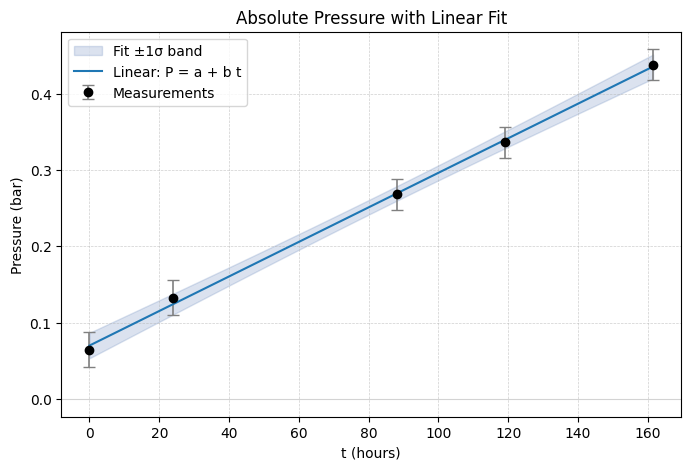

In [12]:
# Fit linear model and visualize data
df = analysis_results["data"]
times = analysis_results["times_hours"]
pressures = analysis_results["pressures_bar"]
sigma_arr = analysis_results["sigma_array"]

time_span = times[-1] - times[0]
slope_guess = (pressures[-1] - pressures[0]) / time_span if time_span else 0.0

linear_result = fit_model(
    times,
    pressures,
    sigma_arr,
    linear_model,
    p0=(pressures[0], slope_guess),
    bounds=([-np.inf, -np.inf], [np.inf, np.inf]),
    param_names=("a", "b"),
    label="Linear: P = a + b t",
)

analysis_results["fits"] = {"linear": linear_result}

param_metadata = {
    "a": ("Initial pressure", "bar"),
    "b": ("Absolute rise rate", "bar/h"),
}

derived_df = analysis_results["derived"].copy()
fit_rows = []
for name, value, sigma_val in zip(linear_result["param_names"], linear_result["popt"], linear_result["perr"]):
    label, units = param_metadata.get(name, (name, ""))
    fit_rows.append({
        "quantity": label,
        "value": value,
        "sigma": sigma_val,
        "units": units,
    })

if "b" in linear_result["param_names"]:
    gauge_value = linear_result["popt"][1] / INHG_TO_BAR
    gauge_sigma = linear_result["perr"][1] / INHG_TO_BAR
    fit_rows.append({
        "quantity": "Gauge rise rate (inHg/h)",
        "value": gauge_value,
        "sigma": gauge_sigma,
        "units": "inHg/h",
    })

if fit_rows:
    fit_labels = [row["quantity"] for row in fit_rows]
    derived_df = derived_df[~derived_df["quantity"].isin(fit_labels)]
    derived_df = pd.concat([derived_df, pd.DataFrame(fit_rows)], ignore_index=True)

analysis_results["derived"] = derived_df

derived_scalars = analysis_results.setdefault("derived_scalars", {})
derived_scalars.update(
    {
        "initial_pressure_bar": linear_result["popt"][0],
        "initial_pressure_sigma_bar": linear_result["perr"][0],
        "rise_rate_bar_per_h": linear_result["popt"][1],
        "rise_rate_sigma_bar_per_h": linear_result["perr"][1],
        "rise_rate_inHg_per_h": gauge_value if "b" in linear_result["param_names"] else None,
        "rise_rate_sigma_inHg_per_h": gauge_sigma if "b" in linear_result["param_names"] else None,
    }
)

start_hour, stop_hour, step_hour = CURVE_GRID_RANGE
num_points = int(round((stop_hour - start_hour) / step_hour)) + 1
curve_hours = start_hour + np.arange(num_points) * step_hour
curve_df = pd.DataFrame({"t_hours": curve_hours})

popt = linear_result["popt"]
pcov = linear_result["pcov"]

curve_df["P_linear_bar"] = linear_model(curve_hours, *popt)
design_curve = np.vstack((np.ones_like(curve_hours), curve_hours)).T
curve_var = np.einsum("ij,jk,ik->i", design_curve, pcov, design_curve)
curve_sigma = np.sqrt(np.maximum(curve_var, 0.0))
curve_df["P_linear_sigma_bar"] = curve_sigma

analysis_results["curve_grid"] = curve_df
analysis_results["fit_band_hours"] = curve_hours
analysis_results["fit_band_sigma_bar"] = curve_sigma

print("Updated derived metrics (including fit parameters):")
display(derived_df)

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(
    df["t_hours"],
    df["pressure_bar"],
    yerr=sigma_arr,
    fmt="o",
    color="black",
    ecolor="gray",
    elinewidth=1.2,
    capsize=4,
    label="Measurements",
)

t_plot = np.linspace(0.0, max(df["t_hours"].max(), 1.0), 200)
fit_line = linear_model(t_plot, *popt)
band_design = np.vstack((np.ones_like(t_plot), t_plot)).T
fit_var = np.einsum("ij,jk,ik->i", band_design, pcov, band_design)
fit_sigma = np.sqrt(np.maximum(fit_var, 0.0))

ax.fill_between(
    t_plot,
    fit_line - fit_sigma,
    fit_line + fit_sigma,
    color="#4C72B0",
    alpha=0.2,
    label="Fit ±1σ band",
)

ax.plot(t_plot, fit_line, label=linear_result["label"])
ax.axhline(0.0, color="lightgray", linewidth=0.8)
ax.set_xlabel("t (hours)")
ax.set_ylabel("Pressure (bar)")
ax.set_title("Absolute Pressure with Linear Fit")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
ax.legend()
plt.show()

### Atmosphere-Limited Fit (optional)

Re-fit the data with an exponential approach-to-atmosphere model so the prediction asymptotically approaches 1 atm. The primary linear analysis above remains unchanged, but this supplemental fit helps judge behavior when the vessel is sealed from the ambient.

Asymptotic fit metrics (1σ uncertainties):


,quantity,value,sigma,units
0,Atmosphere differential Delta P,0.951117,0.017684,bar
1,Time constant tau,338.201330,24.672381,hours
2,Initial pressure,0.062133,0.017684,bar
3,Initial rise rate,0.002812,0.000246,bar/h
4,Gauge rise rate (inHg/h),0.083047,0.007279,inHg/h


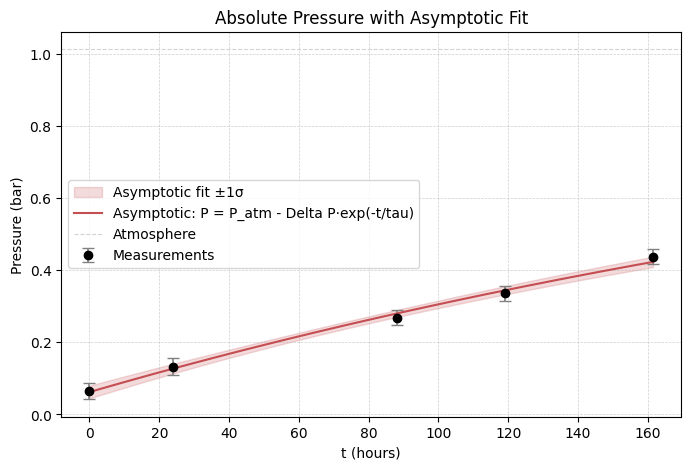

In [13]:
# Supplemental asymptotic fit that enforces an atmospheric asymptote
df = analysis_results["data"]
times = analysis_results["times_hours"]
pressures = analysis_results["pressures_bar"]
sigma_arr = analysis_results["sigma_array"]

time_span = times[-1] - times[0] if len(times) > 1 else 1.0
delta_guess = max(ATMOSPHERE_BAR - pressures[0], 1e-4)

if pressures[-1] < ATMOSPHERE_BAR:
    ratio = (ATMOSPHERE_BAR - pressures[-1]) / max(delta_guess, 1e-6)
    ratio = np.clip(ratio, 1e-6, 0.999999)
    tau_guess = max(-time_span / np.log(ratio), 0.25)
else:
    tau_guess = max(time_span, 0.25)

asymptotic_result = fit_model(
    times,
    pressures,
    sigma_arr,
    asymptotic_model,
    p0=(delta_guess, tau_guess),
    bounds=([1e-6, 1e-6], [ATMOSPHERE_BAR, 1e6]),
    param_names=("delta_p_bar", "tau_hours"),
    label="Asymptotic: P = P_atm - Delta P·exp(-t/tau)",
)

analysis_results.setdefault("fits", {})["asymptotic"] = asymptotic_result

delta_p, tau_hours = asymptotic_result["popt"]
delta_sigma, tau_sigma = asymptotic_result["perr"]
pcov = asymptotic_result["pcov"]

initial_pressure = float(asymptotic_model(0.0, delta_p, tau_hours))
jac_rate = np.array([1.0 / tau_hours, -delta_p / (tau_hours ** 2)])
rise_rate = delta_p / tau_hours
rise_rate_sigma = float(np.sqrt(np.maximum(jac_rate @ pcov @ jac_rate, 0.0)))
gauge_value = rise_rate / INHG_TO_BAR
gauge_sigma = rise_rate_sigma / INHG_TO_BAR

asymptotic_summary_df = pd.DataFrame([
    {"quantity": "Atmosphere differential Delta P", "value": delta_p, "sigma": delta_sigma, "units": "bar"},
    {"quantity": "Time constant tau", "value": tau_hours, "sigma": tau_sigma, "units": "hours"},
    {"quantity": "Initial pressure", "value": initial_pressure, "sigma": delta_sigma, "units": "bar"},
    {"quantity": "Initial rise rate", "value": rise_rate, "sigma": rise_rate_sigma, "units": "bar/h"},
    {"quantity": "Gauge rise rate (inHg/h)", "value": gauge_value, "sigma": gauge_sigma, "units": "inHg/h"},
])

analysis_results["asymptotic_metrics"] = {
    "delta_p_bar": delta_p,
    "delta_p_sigma_bar": delta_sigma,
    "tau_hours": tau_hours,
    "tau_sigma_hours": tau_sigma,
    "initial_pressure_bar": initial_pressure,
    "rise_rate_bar_per_h": rise_rate,
    "rise_rate_sigma_bar_per_h": rise_rate_sigma,
    "rise_rate_inHg_per_h": gauge_value,
    "rise_rate_sigma_inHg_per_h": gauge_sigma,
}

print("Asymptotic fit metrics (1σ uncertainties):")
display(asymptotic_summary_df)

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(
    df["t_hours"],
    df["pressure_bar"],
    yerr=sigma_arr,
    fmt="o",
    color="black",
    ecolor="gray",
    elinewidth=1.2,
    capsize=4,
    label="Measurements",
)

t_plot = np.linspace(0.0, max(df["t_hours"].max(), 1.0), 200)
fit_line = asymptotic_model(t_plot, *asymptotic_result["popt"])
fit_sigma = asymptotic_prediction_sigma(t_plot, asymptotic_result["popt"], pcov)

ax.fill_between(
    t_plot,
    fit_line - fit_sigma,
    fit_line + fit_sigma,
    color="#C44E52",
    alpha=0.2,
    label="Asymptotic fit ±1σ",
)

ax.plot(t_plot, fit_line, color="#C44E52", label=asymptotic_result["label"])
ax.axhline(ATMOSPHERE_BAR, color="lightgray", linewidth=0.8, linestyle="--", label="Atmosphere")
ax.set_xlabel("t (hours)")
ax.set_ylabel("Pressure (bar)")
ax.set_title("Absolute Pressure with Asymptotic Fit")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
ax.legend()
plt.show()

## 6. Derived Gas-Load Metrics

Convert the linear fit slope into useful gas-load quantities with propagated uncertainties.
- **Gauge rise rate** expresses the slope directly in *bar/h*.
- **Throughput Q** converts that slope into bar·L/h for the specified chamber volume.

In [14]:
# Compute derived gas-load metrics
linear_result = analysis_results["fits"]["linear"]
volume_liters = analysis_results["volume_liters"]

rise_rate = linear_result["popt"][1]
rise_rate_sigma = linear_result["perr"][1]

Q = volume_liters * rise_rate
Q_sigma = volume_liters * rise_rate_sigma

derived_df = analysis_results["derived"].copy()
derived_df = derived_df[derived_df["quantity"] != "Throughput Q"]
throughput_row = pd.DataFrame([
    {"quantity": "Throughput Q", "value": Q, "sigma": Q_sigma, "units": "bar·L/h"}
])
derived_df = pd.concat([derived_df, throughput_row], ignore_index=True)

analysis_results["derived"] = derived_df

derived_scalars = analysis_results.setdefault("derived_scalars", {})
derived_scalars.update(
    {
        "Q_barL_per_h": Q,
        "Q_sigma_barL_per_h": Q_sigma,
    }
)

print("Fit-derived metrics (1σ uncertainties):")
display(derived_df)

Fit-derived metrics (1σ uncertainties):


,quantity,value,sigma,units
0,Data span,161.500000,NaN,hours
1,Initial pressure,0.070221,0.016674,bar
2,Absolute rise rate,0.002261,0.000162,bar/h
3,Gauge rise rate (inHg/h),0.066759,0.004797,inHg/h
4,Throughput Q,0.009043,0.000650,bar·L/h


## 7. Water-Equivalent Metrics

- **Water volume equivalent** converts the fitted throughput into an assumed water-release rate (µL/h).
- **Water saturation pressure** provides the equilibrium vapor pressure at the logged chamber temperature for comparison.


In [15]:
# Translate gas load into water-equivalent terms
scalars = analysis_results["derived_scalars"]
derived_df = analysis_results["derived"].copy()
Q_barL_per_h = scalars["Q_barL_per_h"]

sat_pressure_bar = water_vapor_pressure_bar(SYSTEM_TEMP_C)

temp_K = SYSTEM_TEMP_C + 273.15
water_n_dot_per_h = Q_barL_per_h / (R_L_BAR_PER_MOL_K * temp_K)
water_mass_g_per_h = water_n_dot_per_h * MOLAR_MASS_WATER_G_PER_MOL
water_volume_uL_per_h = water_mass_g_per_h * 1000.0  # µL/h because 1 g = 1 mL

water_rows = pd.DataFrame([
    {"quantity": "Water volume equivalent", "value": water_volume_uL_per_h, "sigma": np.nan, "units": "µL/h"},
    {"quantity": "Water saturation pressure", "value": sat_pressure_bar, "sigma": np.nan, "units": "bar"},
])

keep_labels = {"Water volume equivalent", "Water saturation pressure"}
derived_df = derived_df[~derived_df["quantity"].isin(keep_labels)]
derived_df = pd.concat([derived_df, water_rows], ignore_index=True)

analysis_results["derived"] = derived_df
analysis_results["water_metrics"] = {
    "water_volume_uL_per_h": water_volume_uL_per_h,
    "sat_pressure_bar": sat_pressure_bar,
}
analysis_results["derived_scalars"] = analysis_results.get("derived_scalars", {})
analysis_results["derived_scalars"].update({
    "water_volume_uL_per_h": water_volume_uL_per_h,
    "sat_pressure_bar": sat_pressure_bar,
})

print("Fit-derived metrics (1σ uncertainties):")
display(derived_df)


Fit-derived metrics (1σ uncertainties):


,quantity,value,sigma,units
0,Data span,161.500000,NaN,hours
1,Initial pressure,0.070221,0.016674,bar
2,Absolute rise rate,0.002261,0.000162,bar/h
3,Gauge rise rate (inHg/h),0.066759,0.004797,inHg/h
4,Throughput Q,0.009043,0.000650,bar·L/h
5,Water volume equivalent,6.661111,NaN,µL/h
6,Water saturation pressure,0.024781,NaN,bar


## Conclusion

The derived table summarizes the full measurement span alongside the fitted pressure intercept, rise rate, and gas throughput, confirming the system is trending with a very shallow slope.

Translated into water-equivalent terms, that slope corresponds to only a few microlitres per hour. The uncertainty model now reflects the Grade A dial specification: the per-point 1σ values range from approximately 0.60 to 0.67 inHg once resolution is folded in.


## Two Rate-of-Rise Test

- **Step 1:** Pump to deep vacuum (about -0.95 bar gauge), isolate the volume, and log pressure rise for 60-120 minutes.
- **Step 2:** Backfill with dry N2 to ambient, pump down to roughly -0.51 bar gauge, isolate, and log pressure rise for another 60-120 minutes.
- Compare the initial slopes. Leak-dominated behavior predicts a ratio `(dP/dt)|_-0.51 / (dP/dt)|_-0.95` near 0.51/0.95 ≈ 0.54, while outgassing-dominated behavior gives a ratio near 1.
